# Script for generating graphs for KAE EnKF Paper section 5: Tracking and forecasting a pendulum video

In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)

#Set matplotlib settings as required
%matplotlib inline
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from libraries.KAE import KoopmanAE, LinearKoopmanLayer, KEDcoder, gen_jordan_rotation_matrix, LuschLoss
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from libraries.param_opting import run_hyperopt_loop
import pickle
import cv2
from scipy.sparse.linalg import svds
import os
from libraries.DMDEnKF import EnKF, DMD

### Create a dataset for training over the pendulum video data

In [2]:
class PendulumDataset(Dataset):
    
    def __init__(self, mode, first_time_run=False):
        #loads either train or validation data from numpy cylinder flow file depending on mode input
        self.val_amount = 100
        pendulum_data = np.load('data/pendulum.npy',mmap_mode='r')
        #pendulum_data = np.memmap('data/pendulum.npy',mode='r',shape=(523, 576, 720))
        
        if mode == 'train' or 'val':
            self.data = pendulum_data[:-self.val_amount]
            self.flat_data = self.data.reshape(len(self.data),-1)
            self.stacked_flat_data = np.hstack([self.flat_data[:-2],self.flat_data[1:-1],self.flat_data[2:]])
            self.mean = np.mean(self.stacked_flat_data,0)
            self.stacked_flat_data = self.stacked_flat_data - self.mean

        if mode == 'val':
            self.data = pendulum_data[-self.val_amount:]
            self.flat_data = self.data.reshape(len(self.data),-1)
            self.stacked_flat_data = np.hstack([self.flat_data[:-2],self.flat_data[1:-1],self.flat_data[2:]])
            self.stacked_flat_data = self.stacked_flat_data - self.mean
            
        self.original_shape = self.data.shape[1:]
        
        #Now resave stacked_flat_data and reload as memmaps (bit of a quick fix but gets the lazy loading working)
        np.save(f'data/{mode}_stacked_flat_data.npy',self.stacked_flat_data)
        self.stacked_flat_data = np.load(f'data/{mode}_stacked_flat_data.npy', mmap_mode='r')
        
            
    def __len__(self):
        return len(self.stacked_flat_data)
    
    
    def __getitem__(self,index):
        #change this code for full version with random target index and resmaple index if is equal to len -1
        if index >= len(self) - 2:
            index = np.random.randint(0,len(self) - 2)
        target_ind = np.min([index + np.random.randint(1,10),len(self) - 1])
        inp = torch.from_numpy(self.stacked_flat_data[index].astype(np.float32).copy())
        outp = torch.from_numpy(self.stacked_flat_data[target_ind].astype(np.float32).copy())
        delta_t = target_ind - index
        return [inp,delta_t], outp

In [3]:
#Use Sparse SVD for efficiency

class TDMD(DMD):
    """
    Inherits from the DMD class, and changes the DMD method to apply a total least squares fit (Total DMD) instead

    ...

    Attributes
    ----------
    All attributes from DMD class : inherited
    inv_DMD_modes : numpy.array
        Pseudoinverse of the fitted DMD modes stored for convenient reuse, shape [r, state dimension]

    Methods
    -------
    DMD(self,r)
        Used within fit method to apply Total DMD, and calculate DMD modes, eigenvalues and b0
    """
    
    
    def DMD(self,r):
        """
        Used within fit method to calculate DMD modes, eigenvalues and b0 for instance attributes X and Y using Total DMD.

        Parameters
        ----------
        r : int
            Number of modes to truncate the data to, and hence number of DMD modes/eigenvalues to produce
            
        Returns
        -------
        DMD_modes : numpy.array
            Fitted DMD modes arranged as array columns, shape [state dimension, r]
        E : numpy.array
            Eigenvalues associated with each DMD mode, length r
        b0 : numpy.array:
            First state in the data projected onto the DMD modes shape [r, 1]
        """
        
        #Function that takes input/output states matrices and rank of svd truncation
        #Returns DMD modes, relevant eigenvectors and initial conditions
        
        #Set X,Y from instance attributes
        X = self.X
        Y = self.Y
        
        #Project X and Y onto joint subspace
        Z = np.vstack((X,Y))
        zU,zS,zV = svds(Z,r)
        #zv = zV[0:X.shape[0]].T
        #Assume evolution on an r dim subspace
        zv = zV[0:r].T
        X = X@zv@zv.T
        Y = Y@zv@zv.T

        #Take SVD of X
        U,S,V = svds(X,r)

        #Extract high singular value components
        u = U[:,0:r]
        s = S[0:r]
        v = V[0:r].T

        #Use Pseudo-inverse from this approximation of X to create A_tilda (A written in U basis)
        s_inv = np.diag(1/s)
        A_tilda = u.conj().T@Y@v@s_inv

        #Find eigs of A_tilda, return eigvals as a list and eigvecs as columns of an array
        E, eigvecs = np.linalg.eig(A_tilda)
        
        #Convert eigvecs back to standard basis and format eigvals as a diagonal matrix
        #PROJECTED DMD MODES
        #DMD_modes = u@eigvecs
        #EXACT DMD MODES
        DMD_modes = Y@v@s_inv@eigvecs
        DMD_modes = DMD_modes/np.linalg.norm(DMD_modes,axis=0)
        inv_DMD_modes = np.linalg.pinv(DMD_modes)

        #calculate initial coniditons in u basis
        x0 = X[:,0].reshape(-1,1)
        b0 = np.linalg.pinv(DMD_modes)@x0

        #Finally return the 2 matrices and 1 vector needed to project states forward in time
        #This projection is DMD_modes@exp(E*t)@b0 in continuous time and DMD_modes@(E**t)@b0 in discrete time
        self.DMD_modes = DMD_modes
        self.inv_DMD_modes = inv_DMD_modes
        E = np.array([e if abs(np.imag(e))>10**-8 else np.real(e) for e in E])
        self.E = E
        self.b0 = b0
        return DMD_modes, E, b0

### Load the state dict of model parameters for the best performing pendulum model

In [4]:
#ALL PARAMETERS
problem = 'pendulum'

#training
batch_size = 64
epochs = 200
global_fourier_interval = 10
print_interval = 10

#dataset and dataloaders
train_dataset = PendulumDataset(mode='train')
train_dataloader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)

val_dataset = PendulumDataset(mode='val')
val_dataloader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)


#KAE variables
input_size = train_dataset.stacked_flat_data.shape[-1]
num_frequencies = 1
'''encoder_module_list = nn.ModuleList([nn.Linear(input_size,50,),nn.ReLU(),nn.Linear(50,num_frequencies*2)])
decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,50),nn.ReLU(),nn.Linear(50,input_size)])'''

encoder_module_list = nn.ModuleList([nn.Linear(input_size,20,),nn.ReLU(),nn.Linear(20,10,),nn.ReLU(),nn.Linear(10,num_frequencies*2)])
decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,10),nn.ReLU(),nn.Linear(10,20,),nn.ReLU(),nn.Linear(20,input_size)])

#Random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
#initialise Koopman AE, init weights, loss function and optimiser and attatch them to the KAE class
kae = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list)

#find svd to use as initialisation for the
if not os.path.exists(f'data/{problem}_U.npy'):
    U, _, _ = svds(train_dataset.stacked_flat_data.T,k=50)
    np.save(f'data/{problem}_U.npy',U)
U = np.load(f'data/{problem}_U.npy', mmap_mode='r')
U = torch.from_numpy(U.astype(np.float32).copy())

#set loss function
lossfunc = LuschLoss
#this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
#standard, linear, reconstruction, amplitude stability, regularisation
loss_hyperparameters = [1,1,1000,1,0.0001]
opt = optim.AdamW(kae.parameters(),lr=0.001,weight_decay=0)

kae.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=U)
#del U to save memory as saved in KAE as attribute
del U

#Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
kae = kae.to(dev)
kae.device = dev
kae.linear_koopman_layer.device = dev

kae.load_state_dict(torch.load('pickles/3layerdeep-stacked-pendulum-1-mode-model.pt'))
kae.eval()

KoopmanAE(
  (encoder): RecursiveScriptModule(
    original_name=KEDcoder
    (module_list): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): RecursiveScriptModule(original_name=Linear)
      (3): RecursiveScriptModule(original_name=ReLU)
      (4): RecursiveScriptModule(original_name=Linear)
    )
  )
  (decoder): RecursiveScriptModule(
    original_name=KEDcoder
    (module_list): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): RecursiveScriptModule(original_name=Linear)
      (3): RecursiveScriptModule(original_name=ReLU)
      (4): RecursiveScriptModule(original_name=Linear)
    )
  )
  (linear_koopman_layer): LinearKoopmanLayer()
)

### Train a TDMD model over the time delayed data

In [5]:
f = TDMD()
f.fit(train_dataset.stacked_flat_data.T,2)

(array([[-7.52305079e-05-2.71644839e-05j, -7.52305079e-05+2.71644839e-05j],
        [-7.52305079e-05-2.71644839e-05j, -7.52305079e-05+2.71644839e-05j],
        [-7.52305079e-05-2.71644839e-05j, -7.52305079e-05+2.71644839e-05j],
        ...,
        [ 1.23114730e-06+1.56805091e-05j,  1.23114730e-06-1.56805091e-05j],
        [ 1.23114730e-06+1.56805091e-05j,  1.23114730e-06-1.56805091e-05j],
        [ 1.23114730e-06+1.56805091e-05j,  1.23114730e-06-1.56805091e-05j]]),
 array([0.99779402+0.0019361j, 0.99779402-0.0019361j]),
 array([[-1197.8528668-4860.41370099j],
        [-1197.8528668+4860.41370099j]]))

### Show the raw pendulum video data

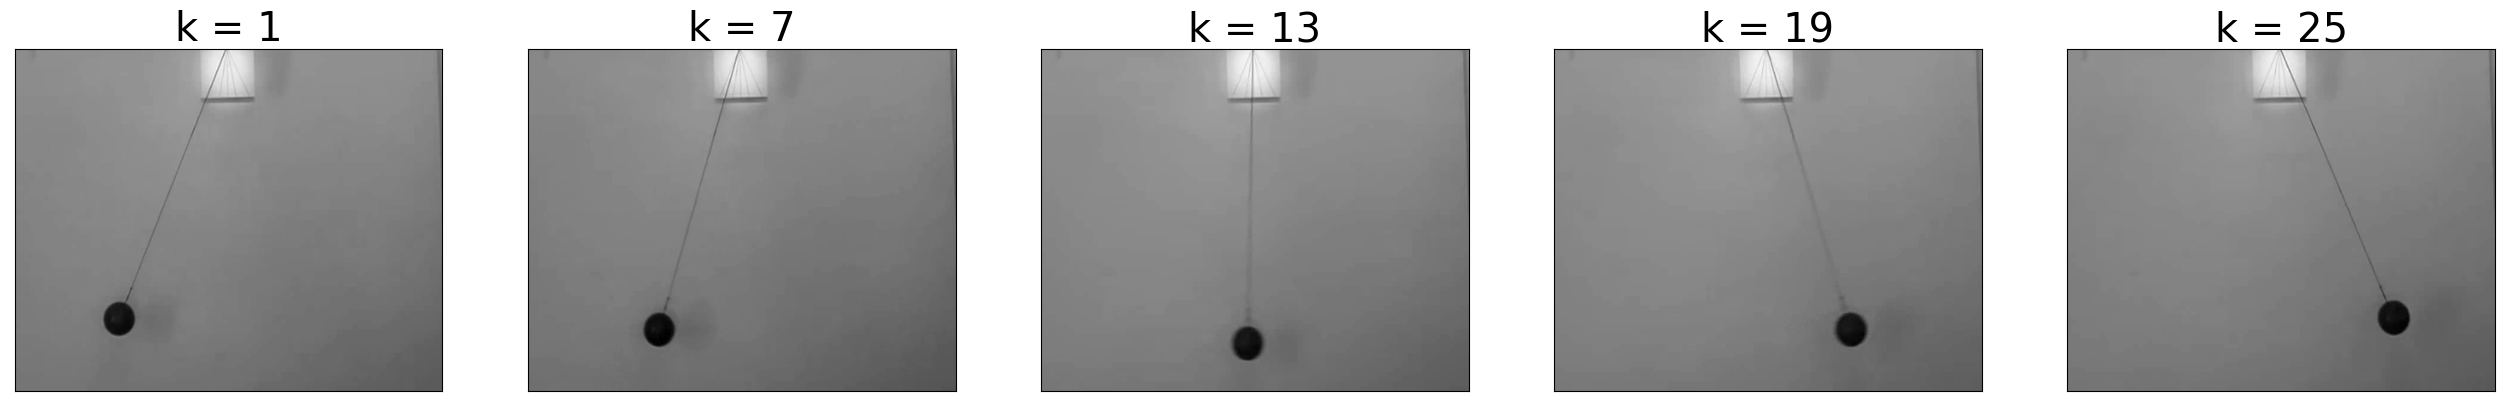

In [6]:
pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6+1}')
    plt.imshow(train_dataset.data[i*6],cmap='gray')
#plt.savefig('graphs/pendulum_example_data',bbox_inches='tight')

### Generate latent representations for TDMD and the KAE EnKF

In [7]:
#EDMD Latent reconstruction

lat_v = np.real(f.DMD_modes[:,0])
lat_v = lat_v/np.linalg.norm(lat_v)

latent_true = lat_v@train_dataset.stacked_flat_data.T
latent_recon = [lat_v@(f.DMD_modes@(np.linalg.matrix_power(np.diag(f.E),t)@f.inv_DMD_modes@train_dataset.stacked_flat_data[0])) for t in range(len(train_dataset))]


#KAE EnKF Latent Reconstruction
#generate encoded x in latent space
forecast_horizon = 0

xs = torch.from_numpy(train_dataset.stacked_flat_data.astype(np.float32).copy())
dts = torch.ones(len(xs))*forecast_horizon

enc_x_latent = kae([xs,dts])[-1].detach().numpy()

#forecasting from x0 in latent space

dts = torch.tensor((range(len(xs))))
xs_to_forecast_from = torch.vstack([xs[0]]*len(xs))

kaeenkf_latent_recon = kae([xs_to_forecast_from,dts])[1].detach().numpy()

/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


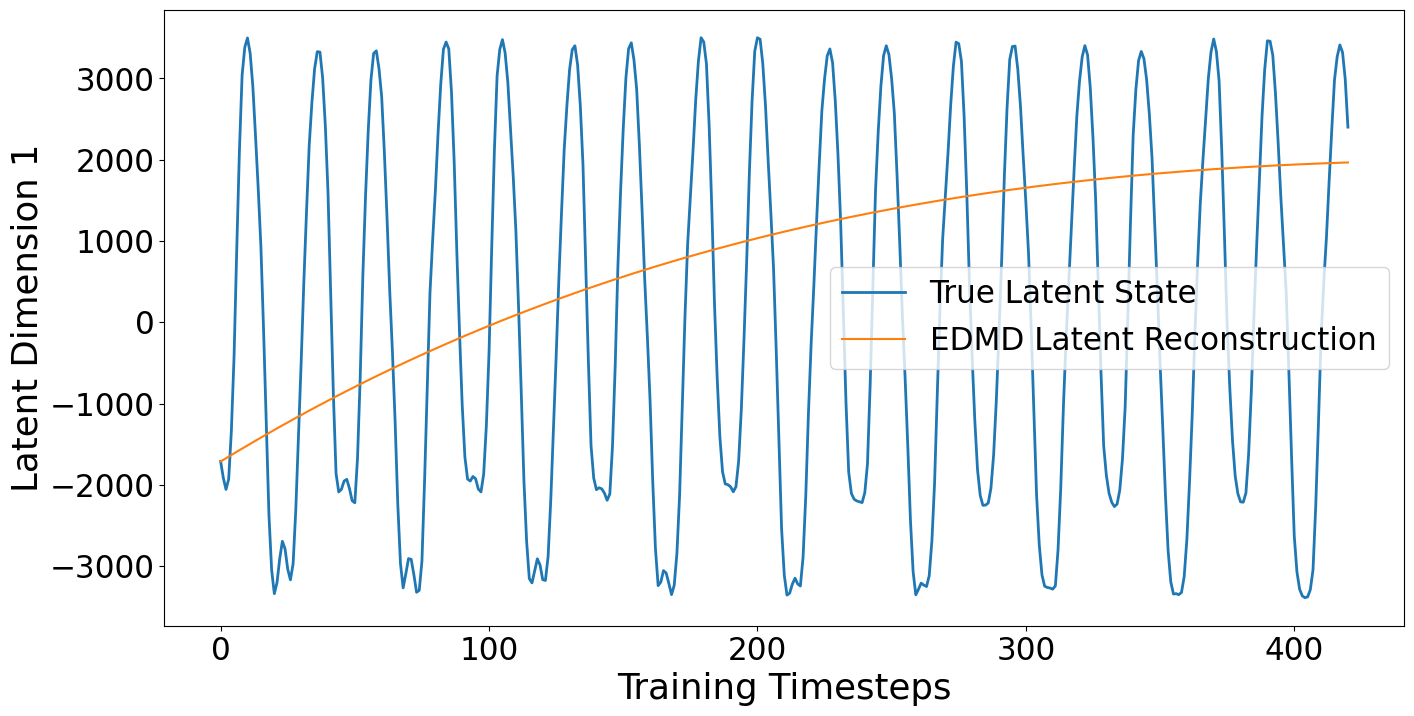

In [8]:
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(latent_true,label='True Latent State',color='tab:blue',linewidth=2)
plt.plot(latent_recon, label='EDMD Latent Reconstruction',color='tab:orange')

plt.xlabel('Training Timesteps')
plt.ylabel('Latent Dimension 1')
plt.legend()
#plt.savefig('graphs/pendulum_edmd_latent_reconstruction',bbox_inches='tight')

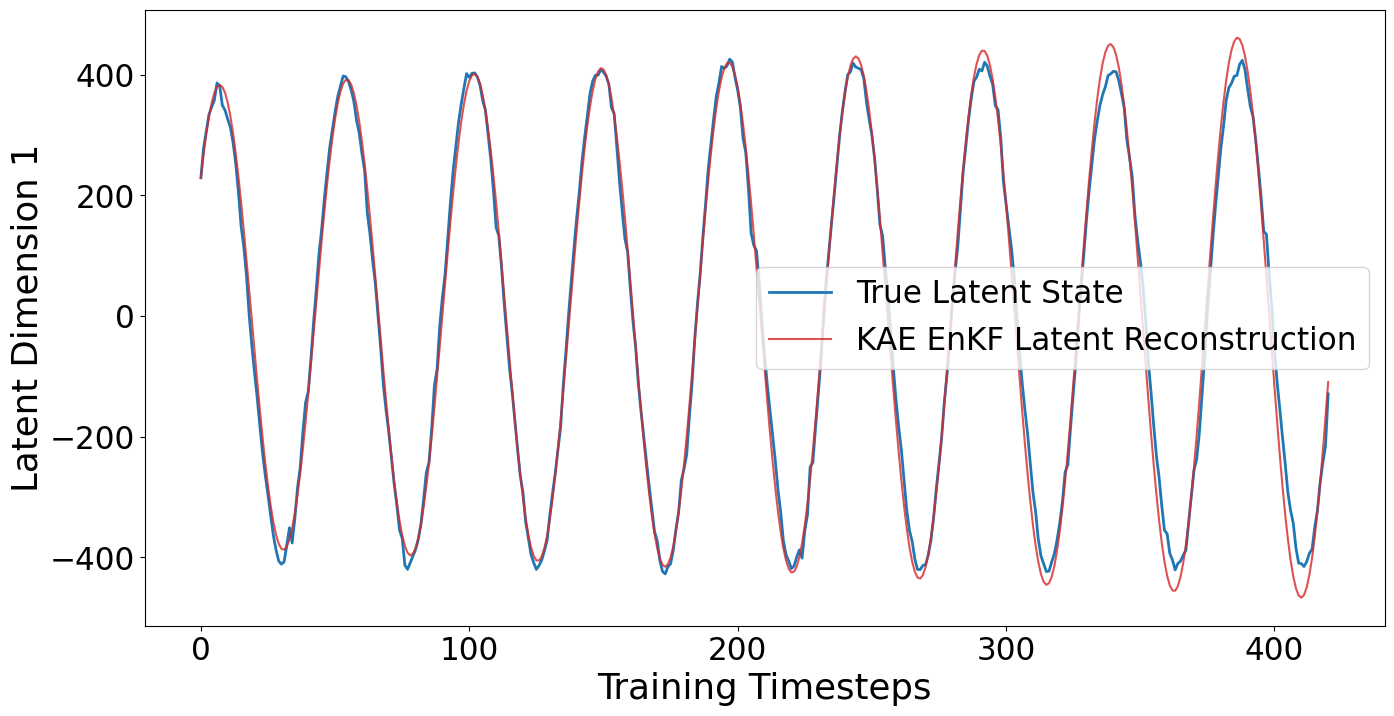

In [9]:
plt.plot(enc_x_latent.T[0],label='True Latent State',color='tab:blue',linewidth=2)
plt.plot(kaeenkf_latent_recon.T[0],label='KAE EnKF Latent Reconstruction',color='tab:red',alpha=0.8)

plt.xlabel('Training Timesteps')
plt.ylabel('Latent Dimension 1')
plt.legend()
#plt.savefig('graphs/pendulum_kaeenkf_latent_reconstruction',bbox_inches='tight')

## View mean subtracted reconstructions for each model

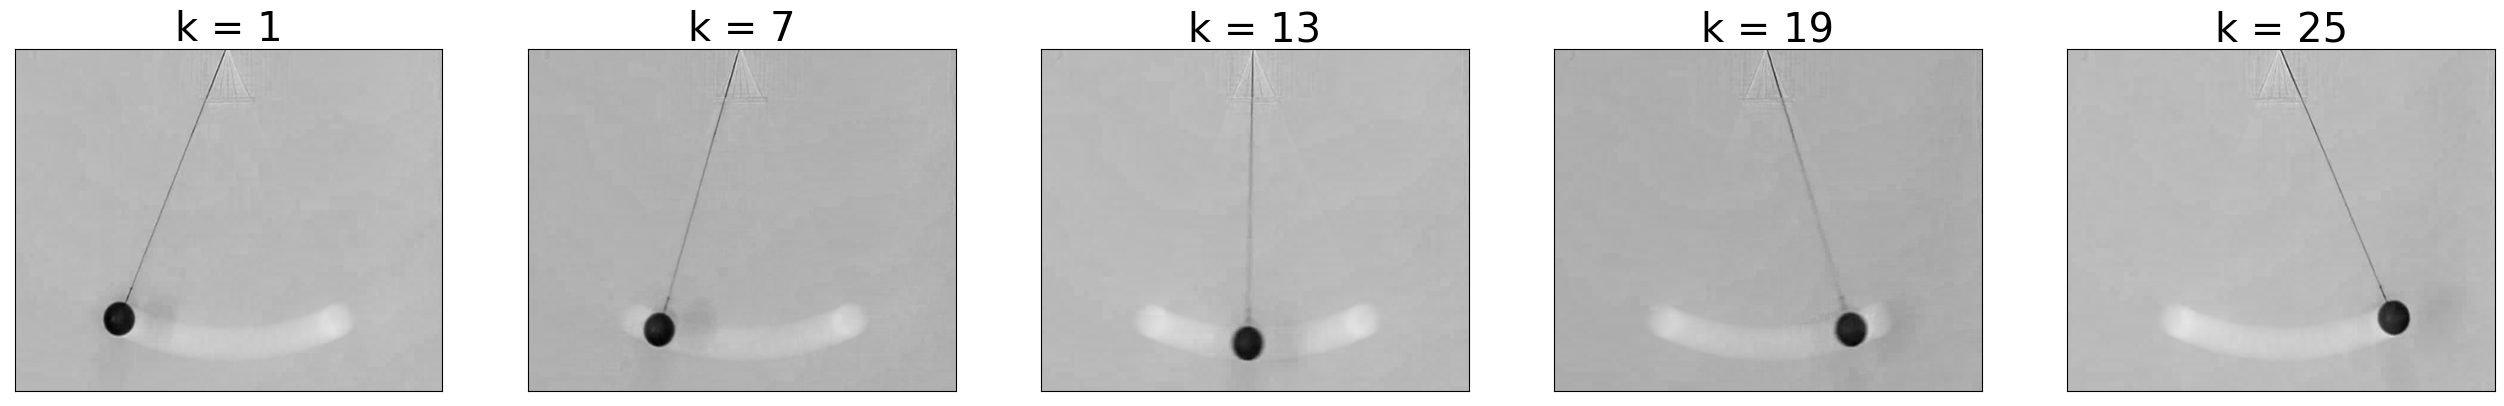

In [10]:
train_data_mean = np.mean(train_dataset.data,axis=0)

pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6+1}')
    plt.imshow(train_dataset.data[i*6] - train_data_mean,cmap='gray')
#plt.savefig('graphs/pendulum_example_data_mean_removed',bbox_inches='tight')

In [11]:
#edmd encode then decode
full_recon = f.DMD_modes@(f.inv_DMD_modes@train_dataset.stacked_flat_data.T)
image_recon = np.real([np.reshape(ar,train_dataset.original_shape) for ar in np.split(full_recon,3)[0].T])

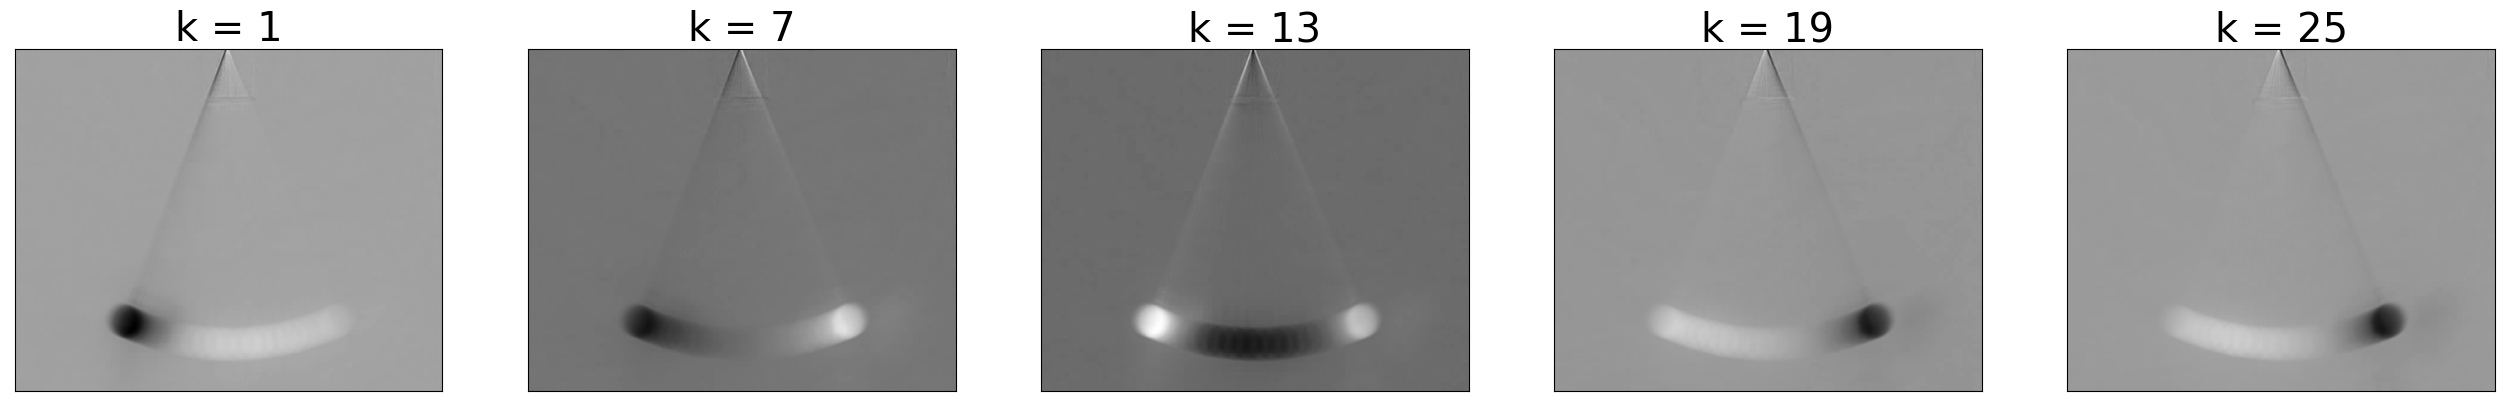

In [12]:
pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6+1}')
    plt.imshow(image_recon[i*6],cmap='gray')
#plt.savefig('graphs/pendulum_edmd_encode_decode',bbox_inches='tight')

In [13]:
#KAE EnKF Full Reconstruction
#generate encoded x in latent space
forecast_horizon = 0

xs = torch.from_numpy(train_dataset.stacked_flat_data.astype(np.float32).copy())
dts = torch.ones(len(xs))*forecast_horizon

full_recon = kae([xs,dts])[0].detach().numpy()
image_recon = np.real([np.reshape(ar,train_dataset.original_shape) for ar in np.split(full_recon.T,3)[0].T])

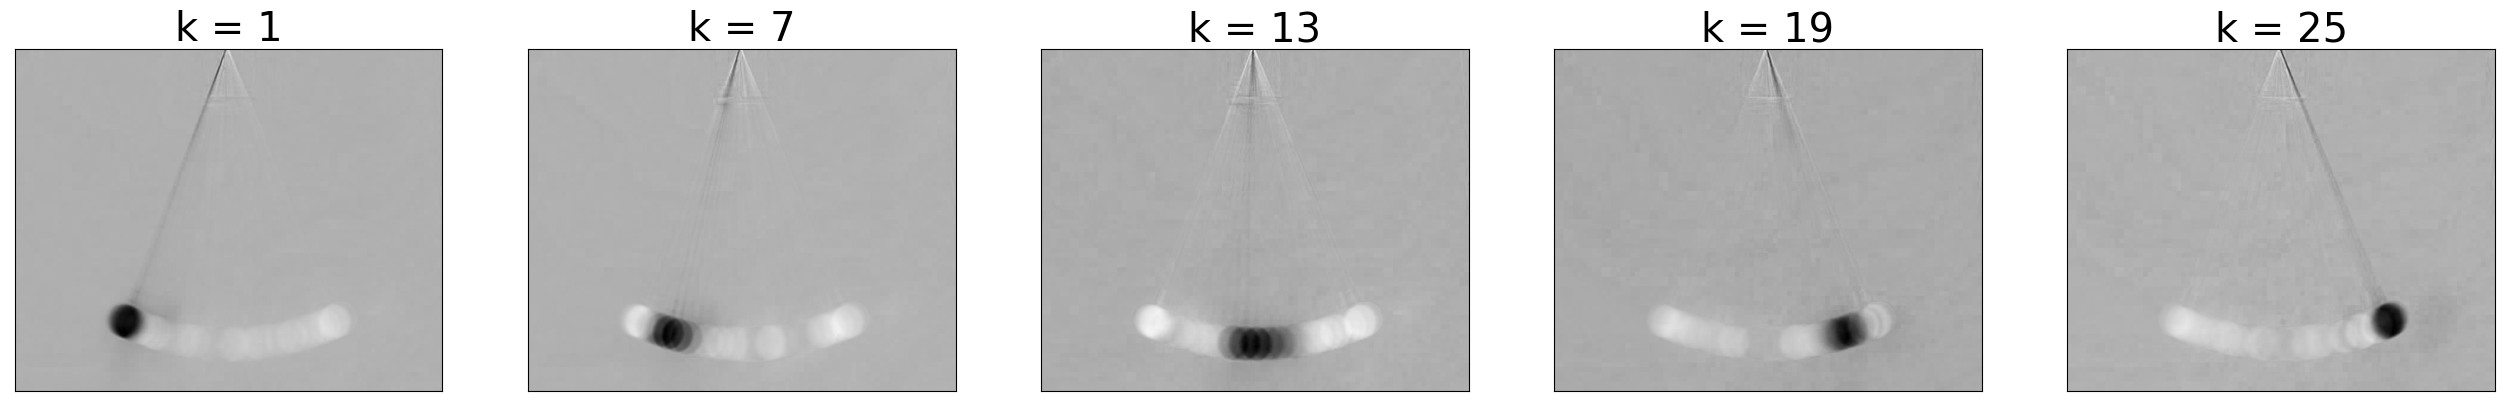

In [14]:
pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6+1}')
    plt.imshow(image_recon[i*6],cmap='gray')
#plt.savefig('graphs/pendulum_kae_enkf_encode_decode',bbox_inches='tight')

### Use the KAE EnkF to forecast, and view latent/full state predicitons

In [ ]:
#Viewing latent space for truth, nstep, let it run, and EnKF nstep

'''#forecasting n steps ahead to see if we get latent forecast matching up with encoded forecast
forecast_horizon = 10

xs = torch.from_numpy(val_dataset.stacked_flat_data.astype(np.float32).copy())
dts = torch.ones(len(xs))*forecast_horizon

forecasts = kae([xs,dts])[1:]
enc_for = forecasts[0][:-forecast_horizon].detach().numpy()
enc_x = forecasts[1][forecast_horizon:].detach().numpy()


#forecasting iteratively to see how this comapres to n-step ahead in latent space

dts = torch.tensor((range(1,len(xs)+1)))

xs_to_forecast_from = torch.vstack([xs[0]]*len(xs))

forecasts = kae([xs_to_forecast_from,dts])[1].detach().numpy()
let_it_run_for = forecasts[forecast_horizon:]'''

#Applying EnKF with filtering of linear koopman layer's frequency and amplitude

sys_cov_const = 0.3**2
param_cov_const = np.array([0.00003**2,0.0003**2])
obs_cov_const = 1**2
init_cov_const = 1**2

Y = kae.encoder(torch.from_numpy(val_dataset.stacked_flat_data.astype(np.float32).copy())).detach().numpy()
x0 = np.hstack([Y[0],
                kae.linear_koopman_layer.amplitudes.detach().numpy(),
                kae.linear_koopman_layer.frequencies.detach().numpy()])
Y = Y[1:]

state_size = Y.shape[-1]
param_size = len(kae.linear_koopman_layer.frequencies)*2

def system_dynamics(ensemble_member):
    #create ensemble dynamics
    amp = torch.tensor([ensemble_member[-2]])
    freq = torch.tensor([ensemble_member[-1]])
    A = gen_jordan_rotation_matrix(amp, freq, 1, kae.device)
                        
    #apply dynamics to ensemble state
    new_ensemble_state = A@ensemble_member[:-2]
    
    #reassemble state_param
    new_ensemble_state = torch.hstack([new_ensemble_state,amp,freq])
    return new_ensemble_state

observation_operator = np.hstack([np.identity(state_size),np.zeros([state_size,param_size])])

system_cov = np.vstack([np.hstack([np.identity(state_size)*sys_cov_const,np.zeros([state_size,param_size])])
                        ,np.hstack([np.zeros([param_size,state_size]),np.identity(param_size)*param_cov_const])])
obs_cov = np.identity(2) * obs_cov_const
P0 = np.vstack([np.hstack([np.identity(state_size)*init_cov_const,np.zeros([state_size,param_size])])
                        ,np.hstack([np.zeros([param_size,state_size]),np.identity(param_size)*param_cov_const])])

ensemble_size = 100

enkf = EnKF(system_dynamics=system_dynamics, observation_operator=observation_operator, system_cov=system_cov,
            observation_cov=obs_cov, x0=x0, P0=P0, ensemble_size=ensemble_size)
    
enkf.fit(Y.T)

#Use EnKF to forecast future states via point estimate in latent space
forecast_horizon = 10

def overall_enkf_forecast(ensembles_list,n_steps):
    return [np.apply_along_axis(enkf_forecast,1,enkf_ensembles,n_steps) for enkf_ensembles in ensembles_list]

def enkf_forecast(ensemble_member,n_steps):
    #create ensemble dynamics
    amp = torch.tensor([ensemble_member[-2]])
    freq = torch.tensor([ensemble_member[-1]])
    A = gen_jordan_rotation_matrix(amp, freq, n_steps, kae.device)
                        
    #apply dynamics to ensemble state
    new_ensemble_state = A@ensemble_member[:-2]
    return new_ensemble_state

enkf_forecasts = overall_enkf_forecast(enkf.ensembles,forecast_horizon)
#point estimate using mean
enkf_forecasts = np.array([np.mean(enkff,axis=0) for enkff in enkf_forecasts])[:-forecast_horizon]

In [16]:
#KAE EnKF Latent Reconstruction
#generate encoded x in latent space
xs = torch.from_numpy(val_dataset.stacked_flat_data.astype(np.float32).copy())
dts = torch.ones(len(xs))*forecast_horizon

enc_x_latent = kae([xs,dts])[-1].detach().numpy()

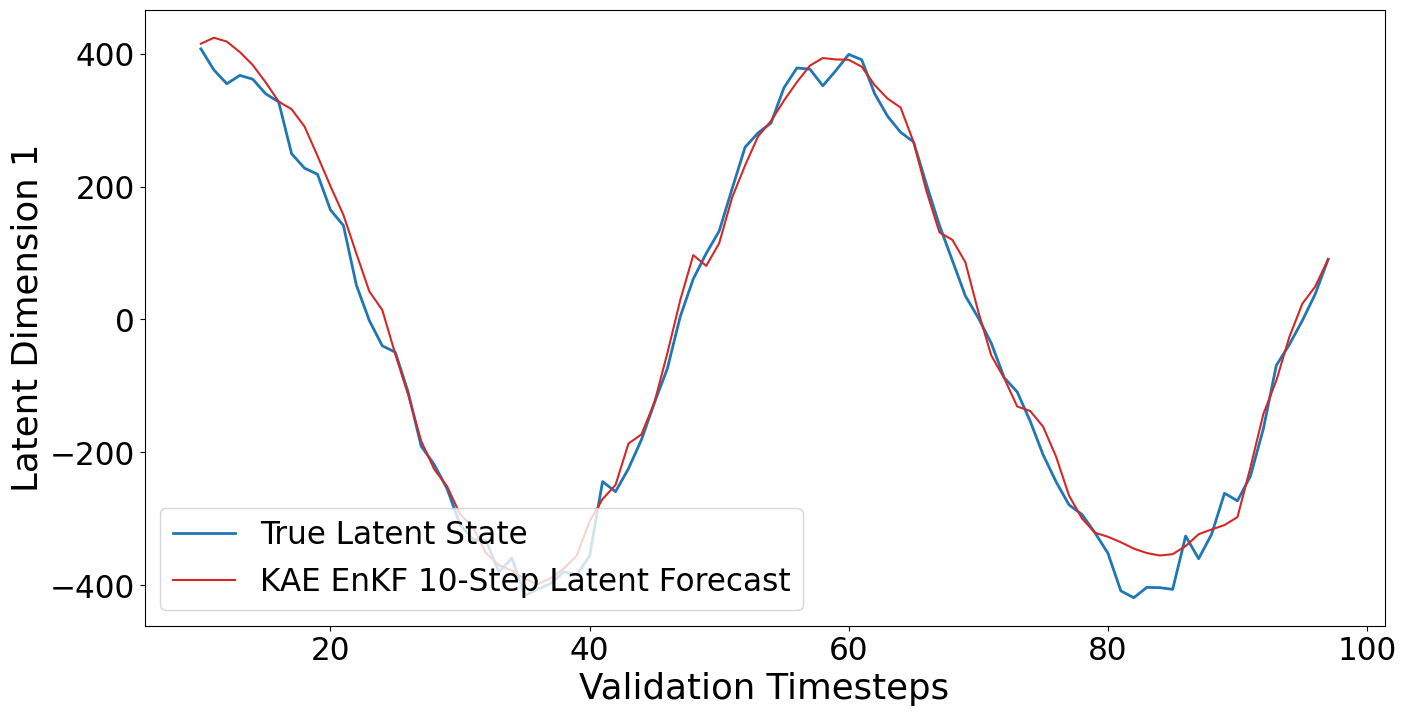

In [17]:
#KAE EnKF Latent Reconstruction
#generate encoded x in latent space
xs = torch.from_numpy(val_dataset.stacked_flat_data.astype(np.float32).copy())
dts = torch.ones(len(xs))*forecast_horizon
enc_x_latent = kae([xs,dts])[-1].detach().numpy()


plt.rcParams["figure.figsize"] = (16,8)
plt.plot(range(10,98),enc_x_latent[forecast_horizon:].T[0],label='True Latent State',color='tab:blue',linewidth=2)
plt.plot(range(10,98),enkf_forecasts.T[0],label='KAE EnKF 10-Step Latent Forecast',color='tab:red')

plt.xlabel('Validation Timesteps')
plt.ylabel('Latent Dimension 1')
plt.legend(loc='lower left')
#plt.savefig('graphs/pendulum_kaeenkf_latent_forecast',bbox_inches='tight')

In [113]:
#full state validation 10-step forecasts

def encx2pic(kae,enc_x,val_dataset):
    with torch.no_grad():
        x = kae.decoder(torch.from_numpy(enc_x.astype(np.float32)))
        relevant_pixels = x[:,-np.prod(val_dataset.original_shape):]
        relevant_pixels = [r.reshape(val_dataset.original_shape) for r in relevant_pixels]
        return relevant_pixels
im_enkf_for = encx2pic(kae,enkf_forecasts,val_dataset)

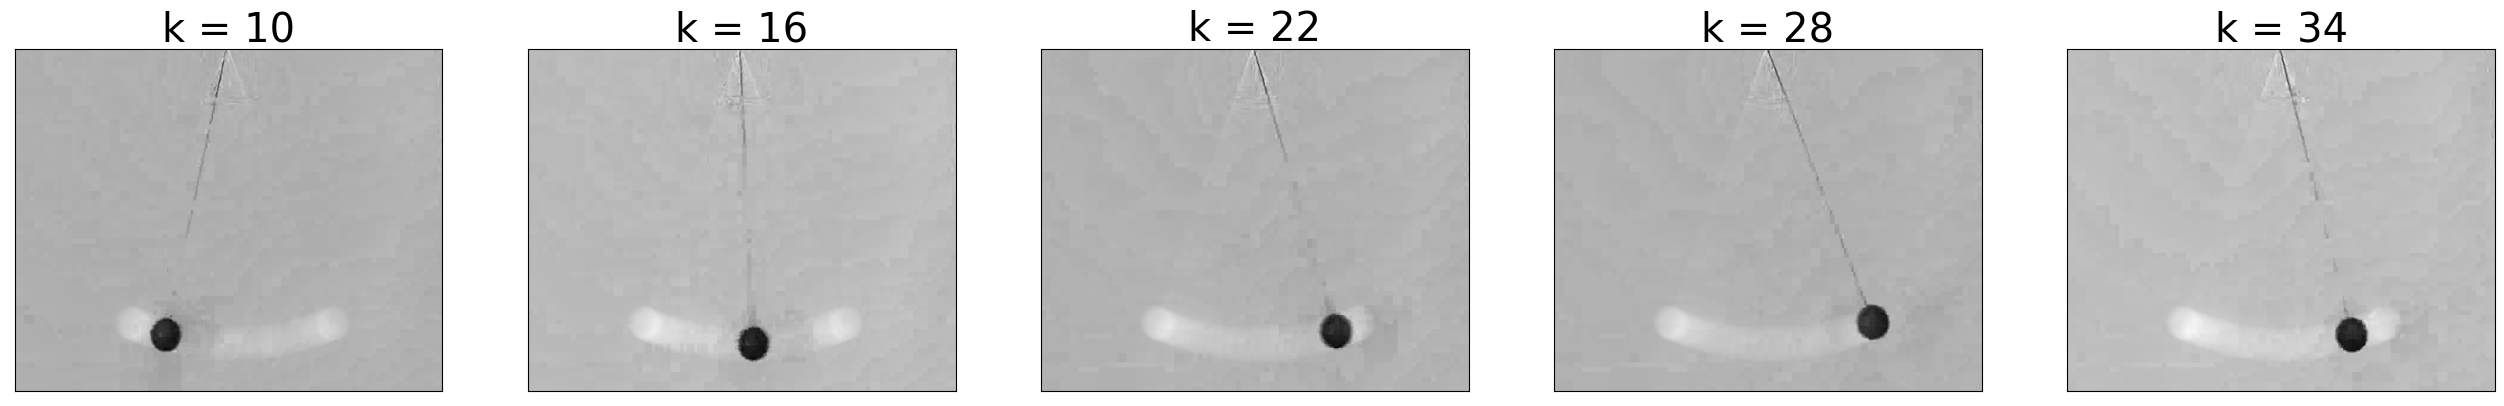

In [114]:
val_data_mean = np.mean(val_dataset.data,axis=0)

pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6+10}')
    plt.imshow(val_dataset.data[-len(im_enkf_for):][i*6] - val_data_mean,cmap='gray')
#plt.savefig('graphs/pendulum_val_data_mean_removed',bbox_inches='tight')

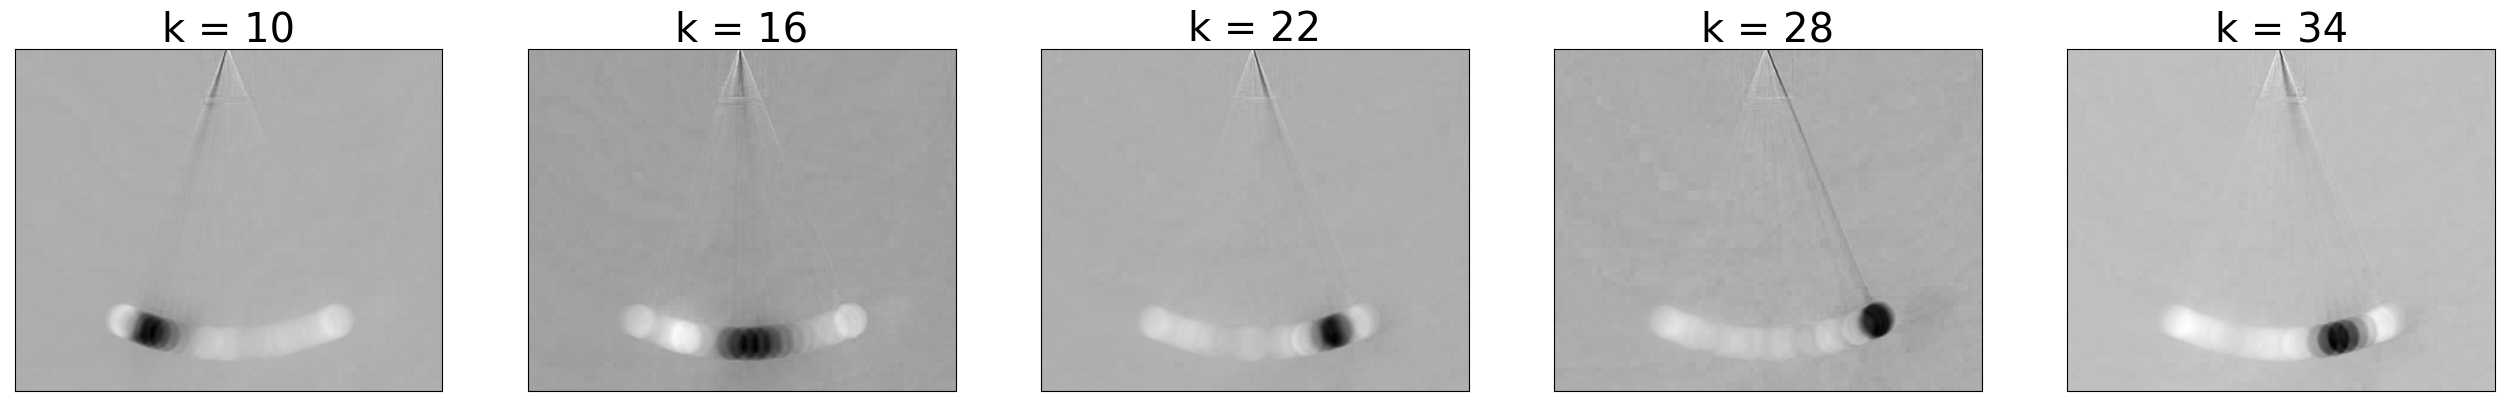

In [115]:
pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6 + 10}')
    plt.imshow(im_enkf_for[i*6],cmap='gray')
#plt.savefig('graphs/pendulum_kae_enkf_val_forecast',bbox_inches='tight')

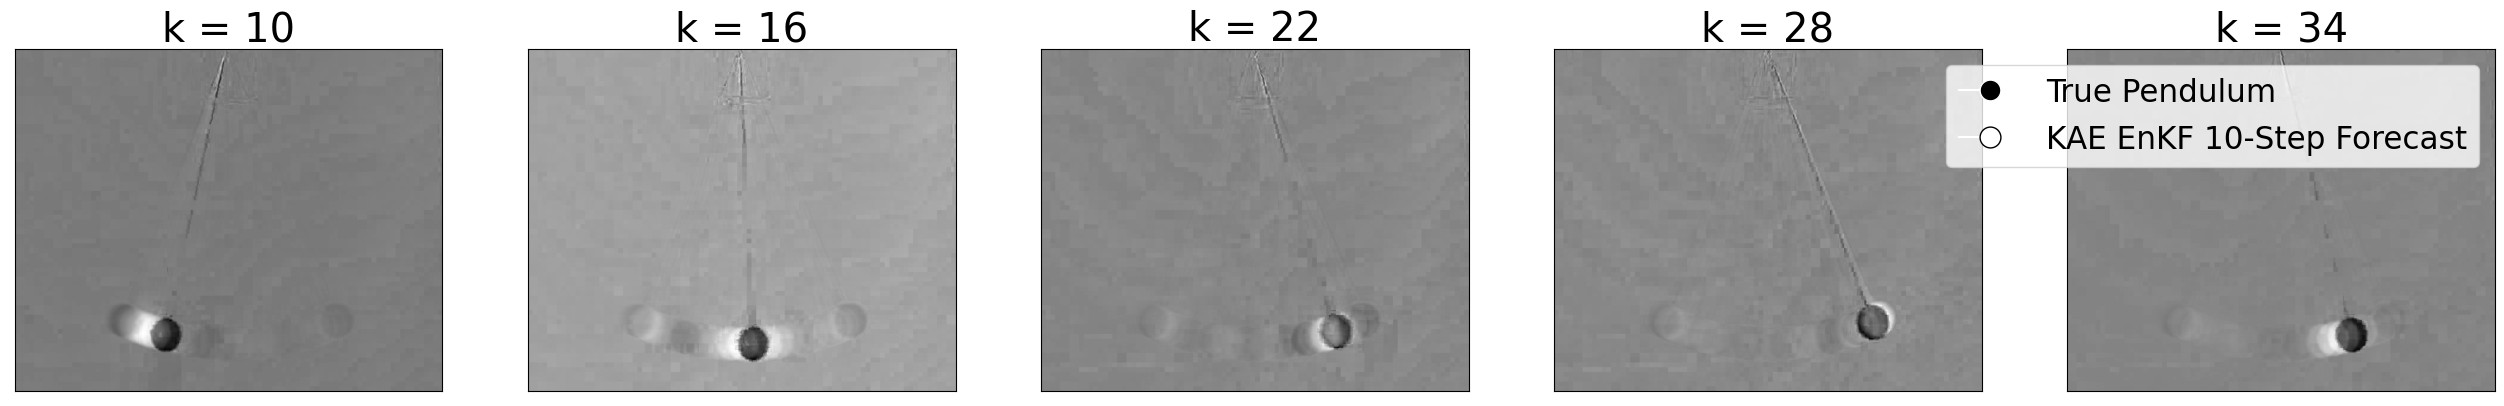

In [124]:
val_data_mean = np.mean(val_dataset.data,axis=0)

pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6+10}')
    plt.imshow((val_dataset.data[-len(im_enkf_for):][i*6] - val_data_mean) - im_enkf_for[i*6].detach().numpy(),cmap='gray')
black_circle = Line2D([0], [0], marker='o', color='w', label='True Pendulum',markerfacecolor='black', markersize=15)
white_circle = Line2D([0], [0], marker='o', color='w', label='KAE EnKF 10-Step Forecast',markerfacecolor='white',markeredgecolor='black', markersize=15)
plt.legend(handles=[black_circle,white_circle])
#plt.savefig('graphs/pendulum_kae_enkf_val_forecast_subtracted',bbox_inches='tight')

### Double the pendulum's frequency, and view how the KAE EnKF adapts

In [125]:
#FREQUENCY DOUBLED DATA!!!

#Viewing latent space for truth, nstep, let it run, and EnKF nstep

#forecasting n steps ahead to see if we get latent forecast matching up with encoded forecast
forecast_horizon = 10

#xs = torch.from_numpy(val_dataset.stacked_flat_data.astype(np.float32).copy())
xs = torch.from_numpy(val_dataset.stacked_flat_data.astype(np.float32).copy())[:-2]
xs = torch.vstack([xs,xs])
xs = torch.vstack([x for i,x in enumerate(xs) if i%2 ==0])
xs = torch.vstack([torch.from_numpy(val_dataset.stacked_flat_data.astype(np.float32))[:-2],xs])
dts = torch.ones(len(xs))*forecast_horizon

forecasts = kae([xs,dts])[1:]
enc_for = forecasts[0][:-forecast_horizon].detach().numpy()
enc_x = forecasts[1][forecast_horizon:].detach().numpy()


#forecasting iteratively to see how this comapres to n-step ahead in latent space

dts = torch.tensor((range(1,len(xs)+1)))

xs_to_forecast_from = torch.vstack([xs[0]]*len(xs))

forecasts = kae([xs_to_forecast_from,dts])[1].detach().numpy()
let_it_run_for = forecasts[forecast_horizon:]

#Applying EnKF with filtering of linear koopman layer's frequency and amplitude

sys_cov_const = 0.3**2
param_cov_const = np.array([0.00003**2,0.0003**2])
obs_cov_const = 1 **2
init_cov_const = 1**2

Y = kae.encoder(xs).detach().numpy()
x0 = np.hstack([Y[0],
                kae.linear_koopman_layer.amplitudes.detach().numpy(),
                kae.linear_koopman_layer.frequencies.detach().numpy()])
Y = Y[1:]

state_size = Y.shape[-1]
param_size = len(kae.linear_koopman_layer.frequencies)*2

def system_dynamics(ensemble_member):
    #create ensemble dynamics
    amp = torch.tensor([ensemble_member[-2]])
    freq = torch.tensor([ensemble_member[-1]])
    A = gen_jordan_rotation_matrix(amp, freq, 1, kae.device)
                        
    #apply dynamics to ensemble state
    new_ensemble_state = A@ensemble_member[:-2]
    
    #reassemble state_param
    new_ensemble_state = torch.hstack([new_ensemble_state,amp,freq])
    return new_ensemble_state




observation_operator = np.hstack([np.identity(state_size),np.zeros([state_size,param_size])])

system_cov = np.vstack([np.hstack([np.identity(state_size)*sys_cov_const,np.zeros([state_size,param_size])])
                        ,np.hstack([np.zeros([param_size,state_size]),np.identity(param_size)*param_cov_const])])
obs_cov = np.identity(2) * obs_cov_const
P0 = np.vstack([np.hstack([np.identity(state_size)*init_cov_const,np.zeros([state_size,param_size])])
                        ,np.hstack([np.zeros([param_size,state_size]),np.identity(param_size)*param_cov_const])])

ensemble_size = 100

enkf = EnKF(system_dynamics=system_dynamics, observation_operator=observation_operator, system_cov=system_cov,
            observation_cov=obs_cov, x0=x0, P0=P0, ensemble_size=ensemble_size)
    
enkf.fit(Y.T)

def overall_enkf_forecast(ensembles_list,n_steps):
    return [np.apply_along_axis(enkf_forecast,1,enkf_ensembles,n_steps) for enkf_ensembles in ensembles_list]

def enkf_forecast(ensemble_member,n_steps):
    #create ensemble dynamics
    amp = torch.tensor([ensemble_member[-2]])
    freq = torch.tensor([ensemble_member[-1]])
    A = gen_jordan_rotation_matrix(amp, freq, n_steps, kae.device)
                        
    #apply dynamics to ensemble state
    new_ensemble_state = A@ensemble_member[:-2]
    return new_ensemble_state

enkf_for = overall_enkf_forecast(enkf.ensembles,forecast_horizon)
#point estimate using mean
enkf_for = np.array([np.mean(enkff,axis=0) for enkff in enkf_for])[:-forecast_horizon]

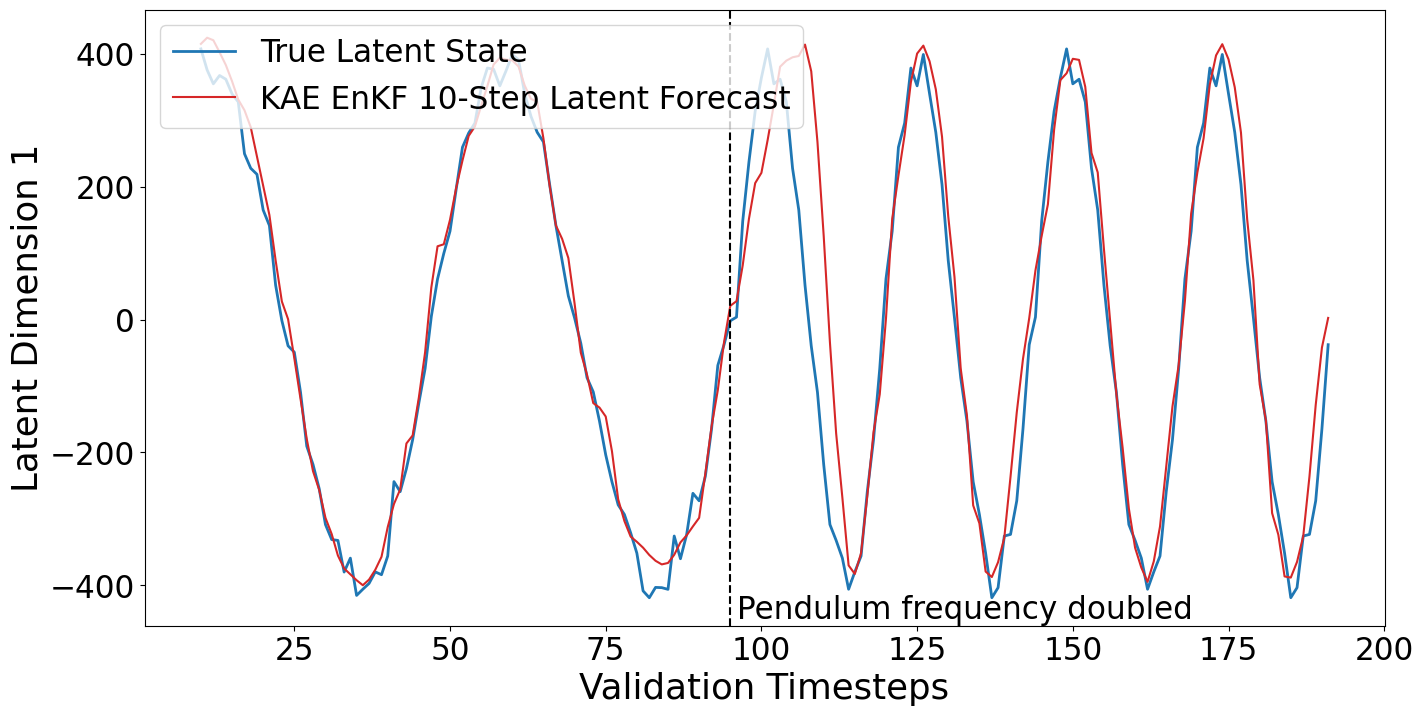

In [126]:
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(range(10,len(enc_x.T[0])+10),enc_x.T[0],label='True Latent State',color='tab:blue',linewidth=2)
plt.plot(range(10,len(enc_x.T[0])+10),enkf_for.T[0], label = 'KAE EnKF 10-Step Latent Forecast',color='tab:red')
plt.legend()
plt.axvline(95,color='black',linestyle='--')
plt.text(96,-450,'Pendulum frequency doubled')
#plt.title('Koopman Autoencoder Latent Space')
plt.xlabel('Validation Timesteps')
plt.ylabel('Latent Dimension 1')
plt.legend(loc='upper left')
#plt.savefig('graphs/pendulum_kaeenkf_latent_freqdoubled_forecast',bbox_inches='tight')

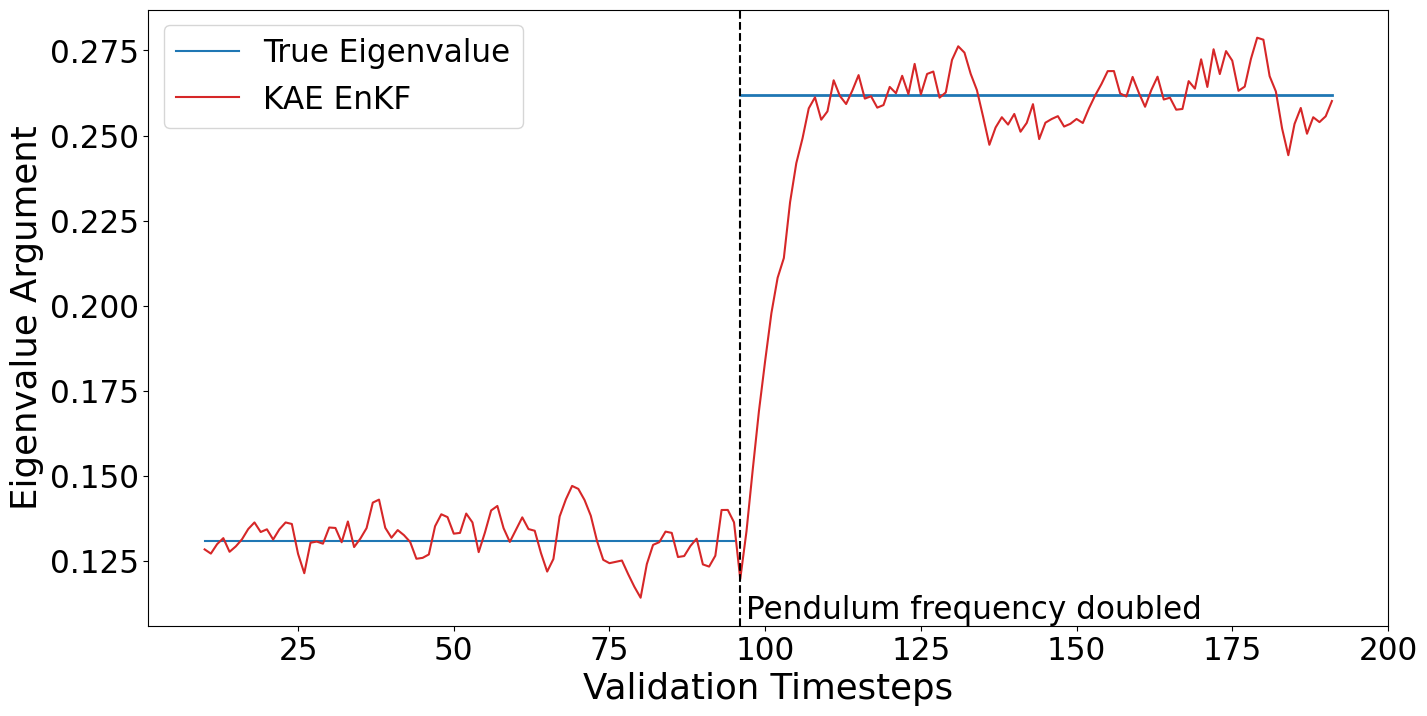

In [128]:
freqs = 2*np.pi - np.array(enkf.X).T[-1]

plt.plot(range(10,96),[2*np.pi/48]*86,color='tab:blue',label='True Eigenvalue')
plt.plot(range(96,96+96),[2*np.pi/24]*96,color='tab:blue',linewidth=2)
plt.plot(range(10,96*2),freqs[10:],color='tab:red', label='KAE EnKF')
plt.axvline(96,color='black',linestyle='--')
plt.text(97,0.108,'Pendulum frequency doubled')
plt.xlabel('Validation Timesteps')
plt.ylabel('Eigenvalue Argument')
plt.legend(loc='upper left')
#plt.savefig('graphs/pendulum_kaeenkf_latent_freqdoubled_frequency',bbox_inches='tight')

In [129]:
#full state validation 10-step forecasts

def encx2pic(kae,enc_x,val_dataset):
    with torch.no_grad():
        x = kae.decoder(torch.from_numpy(enc_x.astype(np.float32)))
        relevant_pixels = x[:,-np.prod(val_dataset.original_shape):]
        relevant_pixels = [r.reshape(val_dataset.original_shape) for r in relevant_pixels]
        return relevant_pixels
im_enkf_for = encx2pic(kae,enkf_for,val_dataset)

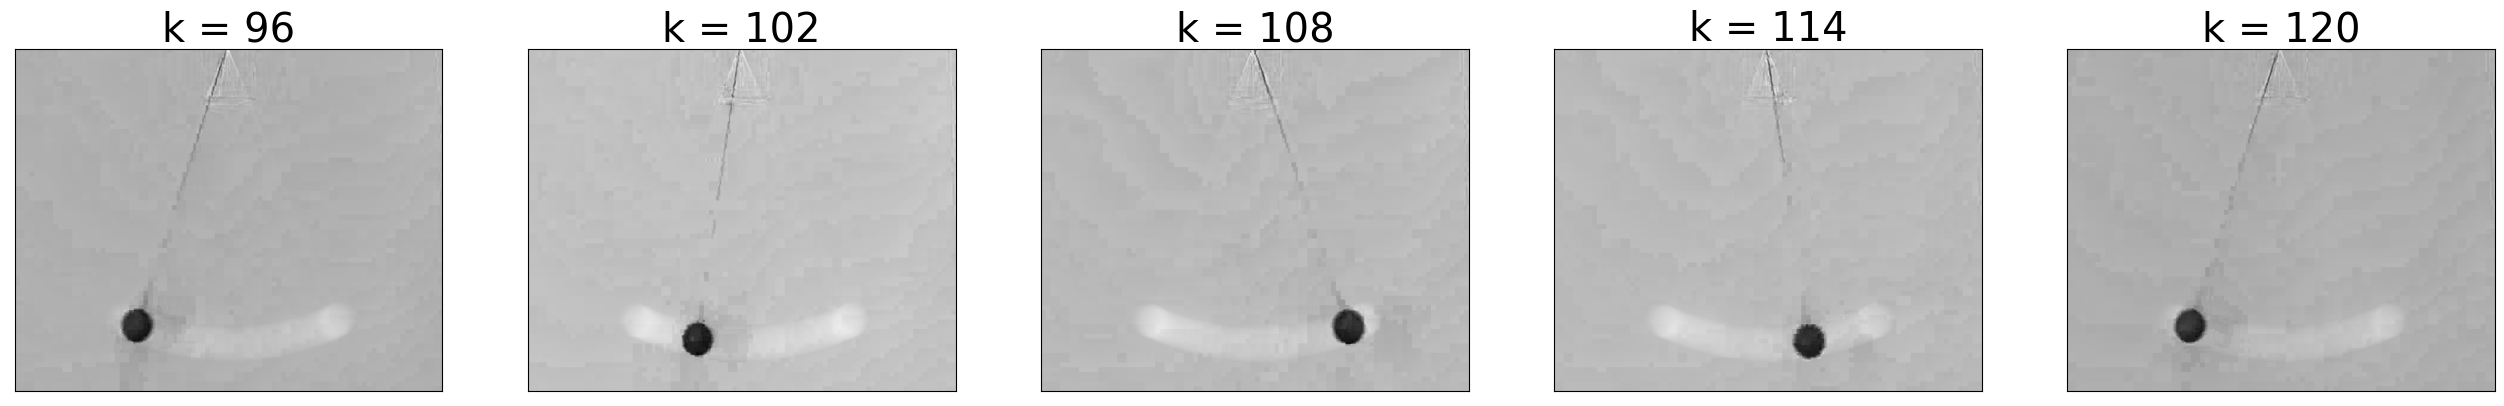

In [150]:
post_doubling_val_imgs = xs[96:]
post_doubling_val_imgs = [np.reshape(ar,train_dataset.original_shape) for ar in np.split(post_doubling_val_imgs.T,3)[-1].T]

pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6+96}')
    plt.imshow(post_doubling_val_imgs[i*6],cmap='gray')
#plt.savefig('graphs/period_doubled_pendulum_val_data_mean_removed',bbox_inches='tight')

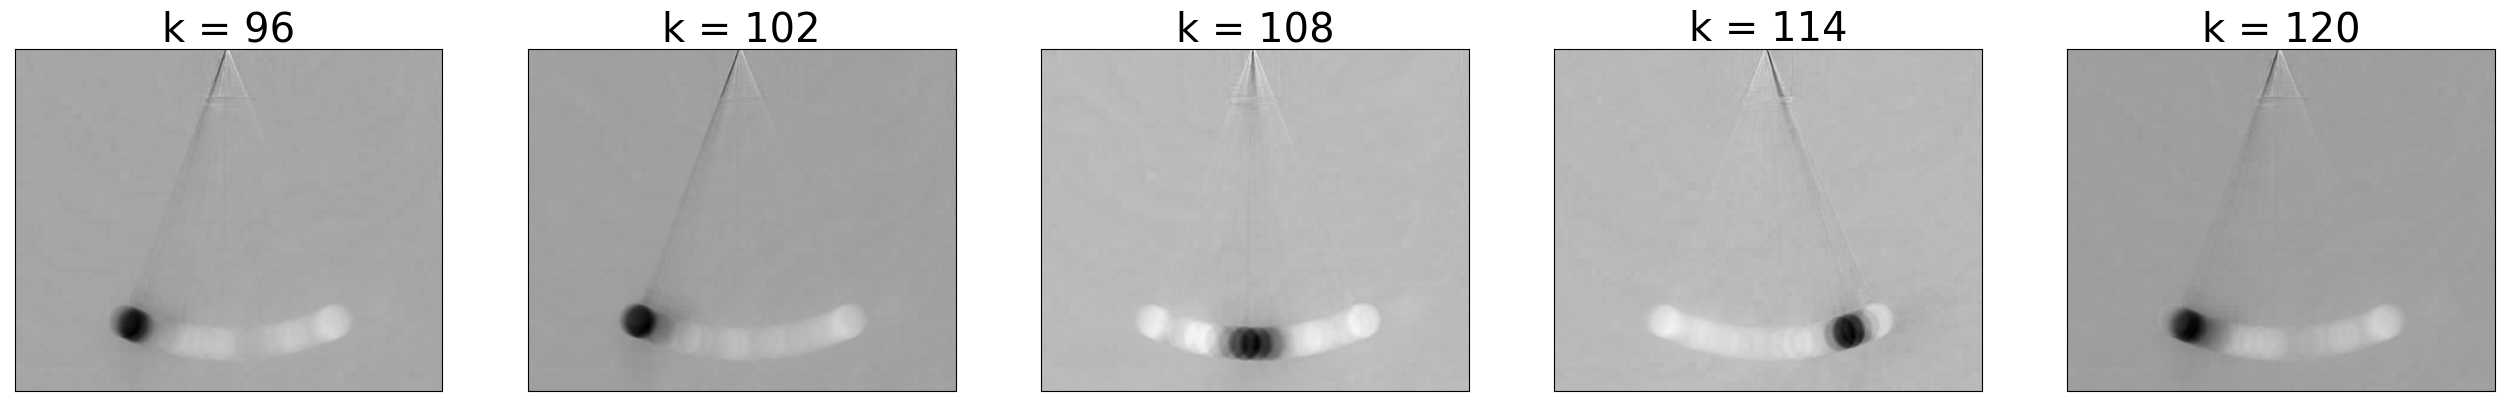

In [151]:
pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6 + 96}')
    plt.imshow(im_enkf_for[i*6+86],cmap='gray')
#plt.savefig('graphs/period_doubled_pendulum_kae_enkf_val_forecast',bbox_inches='tight')

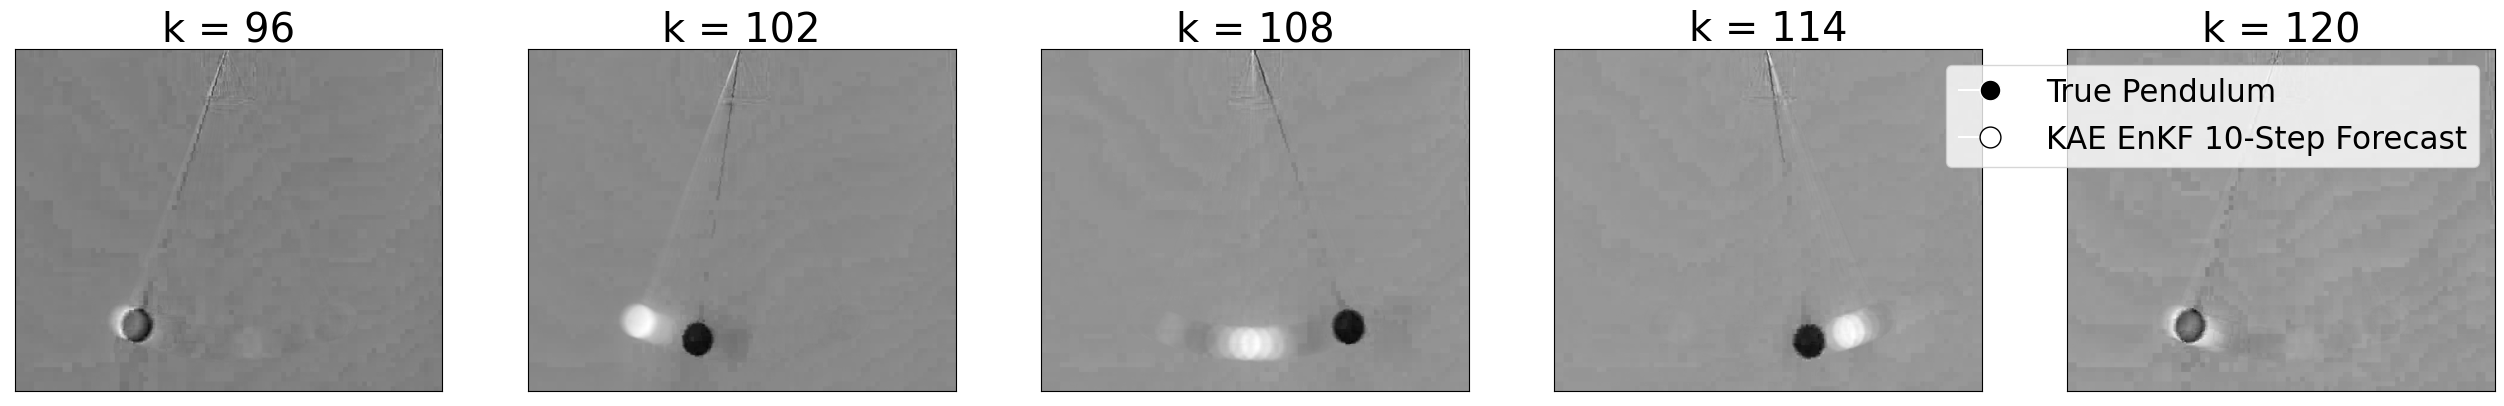

In [152]:
post_doubling_val_imgs = xs[96:]
post_doubling_val_imgs = [np.reshape(ar,train_dataset.original_shape) for ar in np.split(post_doubling_val_imgs.T,3)[-1].T]


pend_plots = 5
height = 8
h2w_ratio = train_dataset.original_shape[0]/train_dataset.original_shape[1]
plt.rcParams["figure.figsize"] = (pend_plots*height*h2w_ratio,height)

fig,ax = plt.subplots(1,pend_plots,sharex=True,sharey=True)
plt.xticks([])
plt.yticks([])
for i in range(pend_plots):
    cax = ax[i]
    plt.sca(cax)
    cax.set_title(f'k = {i*6+96}')
    plt.imshow(post_doubling_val_imgs[i*6] - im_enkf_for[i*6 + 86].detach().numpy(),cmap='gray')
black_circle = Line2D([0], [0], marker='o', color='w', label='True Pendulum',markerfacecolor='black', markersize=15)
white_circle = Line2D([0], [0], marker='o', color='w', label='KAE EnKF 10-Step Forecast',markerfacecolor='white',markeredgecolor='black', markersize=15)
plt.legend(handles=[black_circle,white_circle])
#plt.savefig('graphs/period_doubled_pendulum_kae_enkf_val_forecast_subtracted',bbox_inches='tight')

In [56]:
#frequency of around 48 frames
2*np.pi/48

0.1308996938995747